# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-mc'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(most_uncertain_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6058, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1981, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1276, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.1316, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.1059, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1904, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9679, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0629, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2141, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3208, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0331, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7855
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8179
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9696, F1 Micro: 0.9768, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3025, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8227
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2955, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1999, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0312, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2741, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7494
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7384
Epoch 10/10, Train Loss: 0.0281, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7219
Iteration 320: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7478
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7931
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Iteration 340: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2641, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1807, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2473, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7402
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9663, F1 Micro: 0.9744, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7451
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.0719, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9728, F1 Micro: 0.9792, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1497, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0266, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2471, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0922, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0237, Accuracy

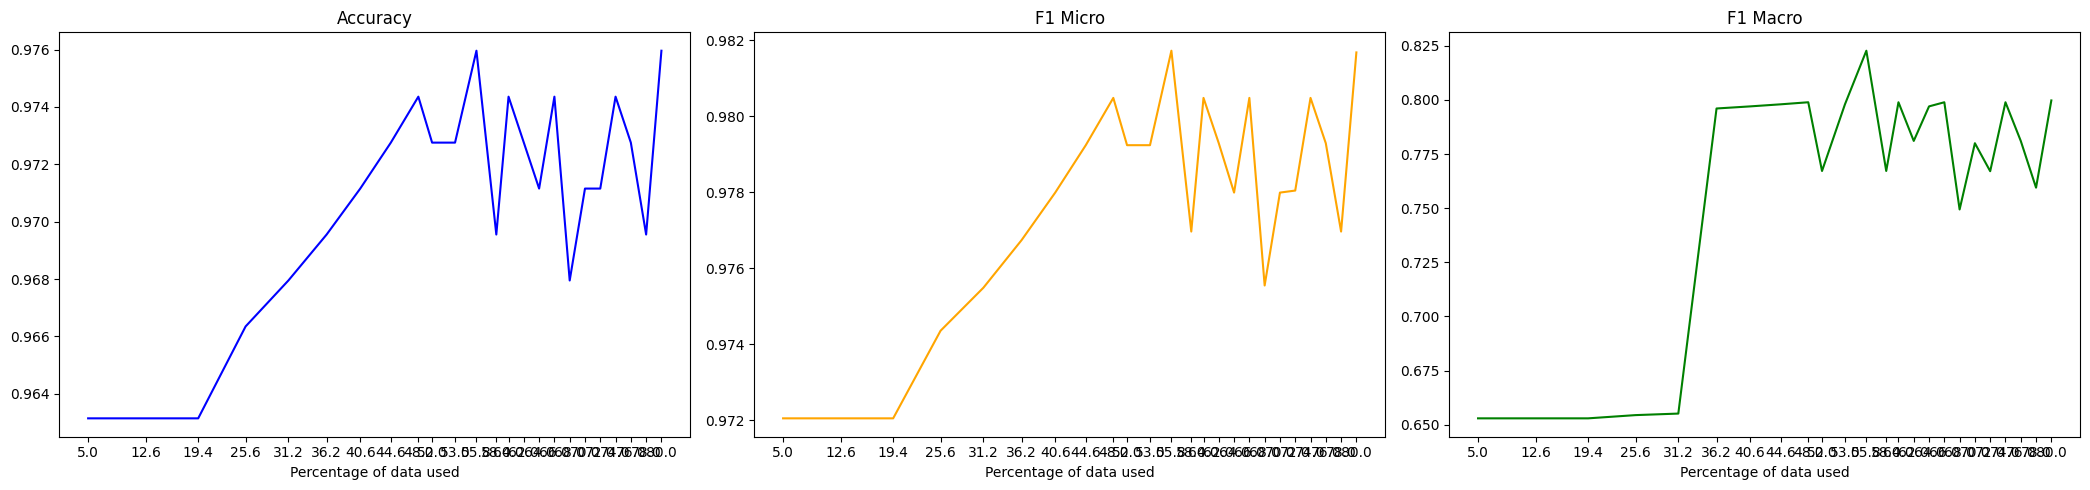

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2886, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5102, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1509, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9663, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1434, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1065, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.384, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2068, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0493, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7264
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9519, F1 Micro: 0.9631, F1 Macro: 0.7309
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7448
Epoch 10/10, Train Loss: 0.0371, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7639
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.046, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7904
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9712, F1 Micro: 0.9779, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9599, F1 Micro: 0.9688, F1 Macro: 0.7149
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.319, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7787
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.0744, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.801
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7882
Iteration 265: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3119, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2947, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.031, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8227
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.276, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8027
Epoch 5/10, Train Loss: 0.0978, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0678, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.805
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7969
Epoch 10/10, Train Loss: 0.0237, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7689
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7459
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8012
Epoch 10/10, Train Loss: 0.0246, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0218, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 5/10, Train Loss: 0.0805, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7976
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0207, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8226
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9744, F1 Micro: 0.9805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1614, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1525, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7967
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7679
Iteration 380: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.9551, F1 Micro: 0.9664, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7458
Epoch 10/10, Train Loss: 0.0199, Accuracy: 0.9647, F1 Micro: 0.973, F1 

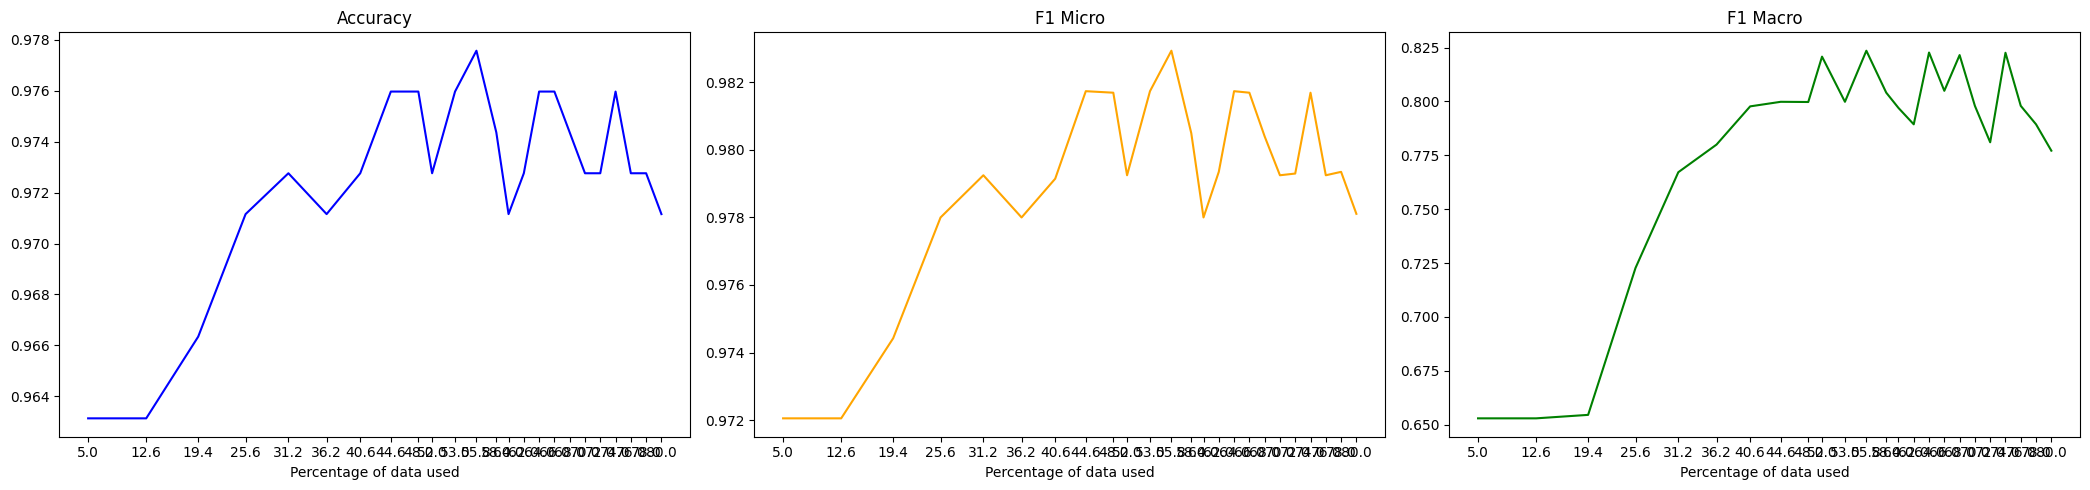

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2201, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1406, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1139, Accuracy: 0.9599, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2405, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6536
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7142
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2075, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1656, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.6959
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6882
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6958
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.9631, F1 Micro: 0.9717, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3432, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6551
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1961, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6904
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7257
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7096
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9631, F1 Micro: 0.9719, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7117
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7068
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7981
Epoch 10/10, Train Loss: 0.0384, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.301, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2099, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7394
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7441
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9728, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2951, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7493
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9535, F1 Micro: 0.9652, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 10/10, Train Loss: 0.0331, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7441
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0238, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1809, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7884
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0311, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9535, F1 Micro: 0.9638, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0731, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0251, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8226
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.976, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1299, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 7/10, Train Loss: 0.044, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2381, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1281, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1545, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.0942, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7987
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7811
Epoch 10/10, Train Loss: 0.0283, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0957, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0298, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7744
Epoch 10/10, Train Loss: 0.018, Accuracy

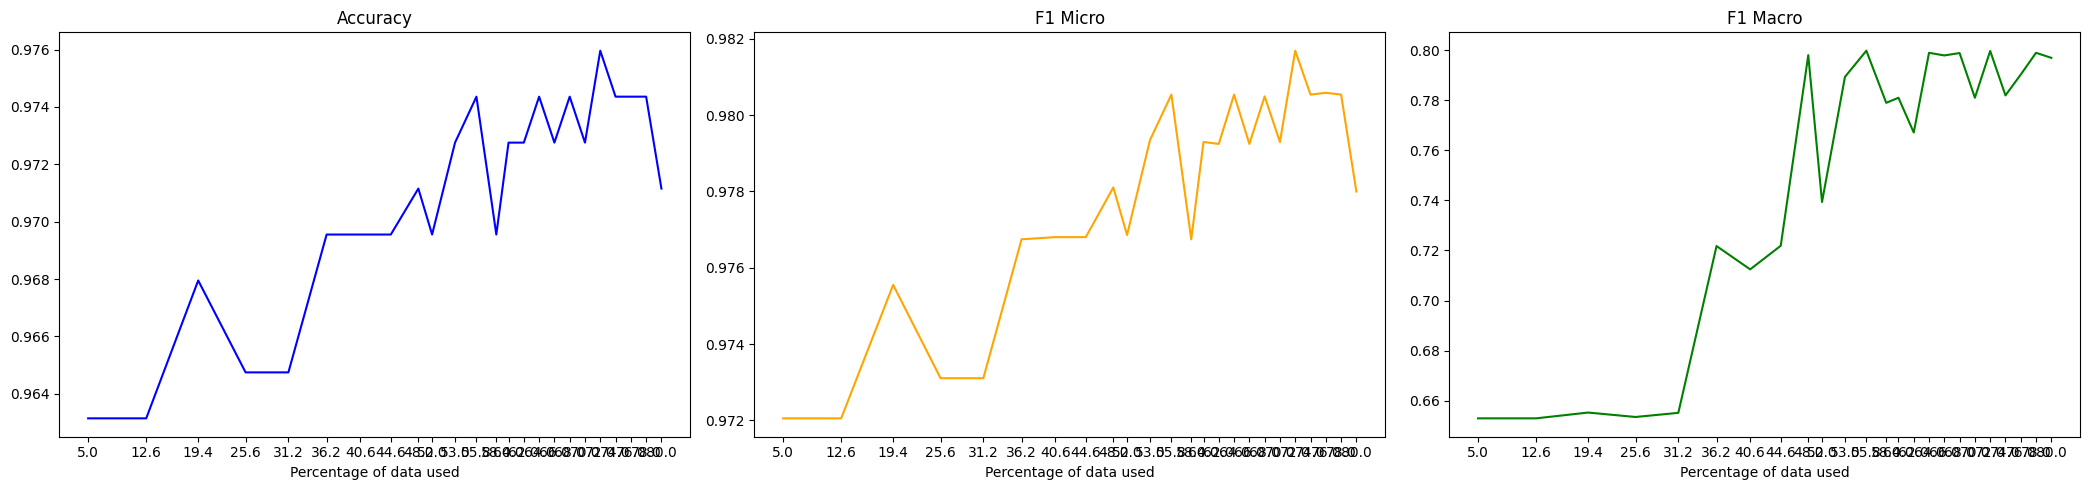

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1641, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1516, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1408, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1332, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1252, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1076, Accuracy: 0.9631, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.318, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1796, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1191, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9631, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1843, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.6465
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.6478
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7069
Iteration 181: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7357
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0397, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.089, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7496
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7404
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9519, F1 Micro: 0.9631, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7869
Epoch 10/10, Train Loss: 0.0364, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8201
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7855
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0284, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7868
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7412
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7847
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7785
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7535
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7414
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.7453
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7458
Iteration 292: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7887
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7731
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7401
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9535, F1 Micro: 0.9653, F1 Macro: 0.7154
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9535, F1 Micro: 0.9654, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7874
Epoch 10/10, Train Loss: 0.0282, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7879
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0478, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8209
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 10/10, Train Loss: 0.0254, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1607, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7868
Epoch 9/10, Train Loss: 0.0265, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0235, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2382, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7915
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8167
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0219, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2336, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.743
Epoch 8/10, Train Loss: 0.0309, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0202, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2327, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1456, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9503, F1 Micro: 0.9612, F1 Macro: 0.752
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8312
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8636
Epoch 10/10, Train Loss: 0.0208, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.213, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7377
Epoch 5/10, Train Loss: 0.0963, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0402, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0211, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.8116
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.221, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1535, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9615, F1 Micro: 0.9712, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0929, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Epoch 7/10, Train Loss: 0.0351, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0283, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7464
Epoch 9/10, Train Loss: 0.0195, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7995
Epoch 10/10, Train Loss: 0.017, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.85
Iteration 390: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1666, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7387
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7855
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.0348, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8288
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8522
Epoch 10/10, Train Loss: 0.0171, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.8162
Iteration 400: Acc

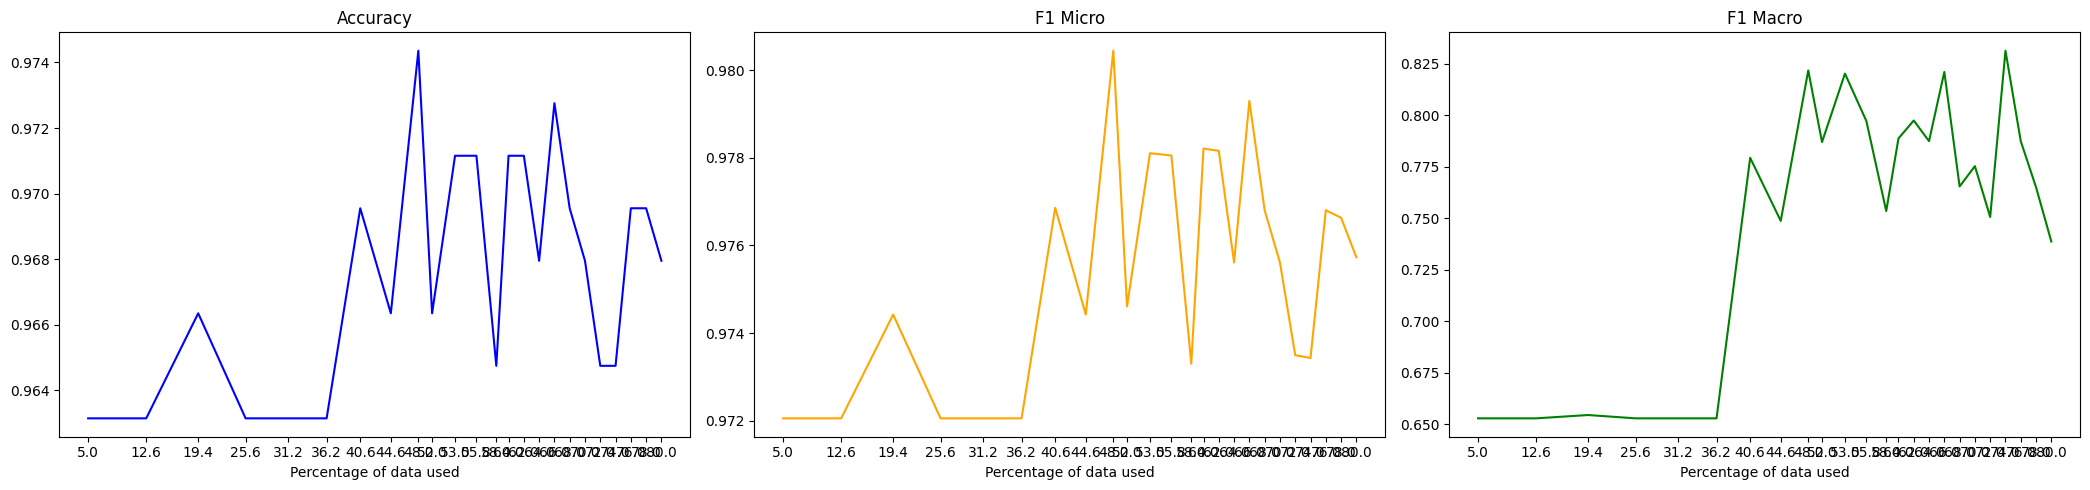

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2011, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2464, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2042, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0908, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1771, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.1015, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7325
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0703, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1555, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3448, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7264
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7442
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3295, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1862, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0457, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2927, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2037, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7323
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0339, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2007, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3052, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1942, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 10/10, Train Loss: 0.0366, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Epoch 10/10, Train Loss: 0.034, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2057, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0361, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.278, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7534
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9631, F1 Micro: 0.9721, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7328
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9615, F1 Micro: 0.971, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0258, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7484
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.751
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9615, F1 Micro: 0.9709, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9712, F1 Micro: 0.9782, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2596, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7396
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0774, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0539, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.018, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2439, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0309, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1395, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.104, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0271, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2416, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7571
Epoch 5/10, Train Loss: 0.089, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2413, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7285
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.9647, F1 Micro: 0.9726, F1 Macro: 0.792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.023, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1641, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9647, F1 Micro: 0.9731, F1 M

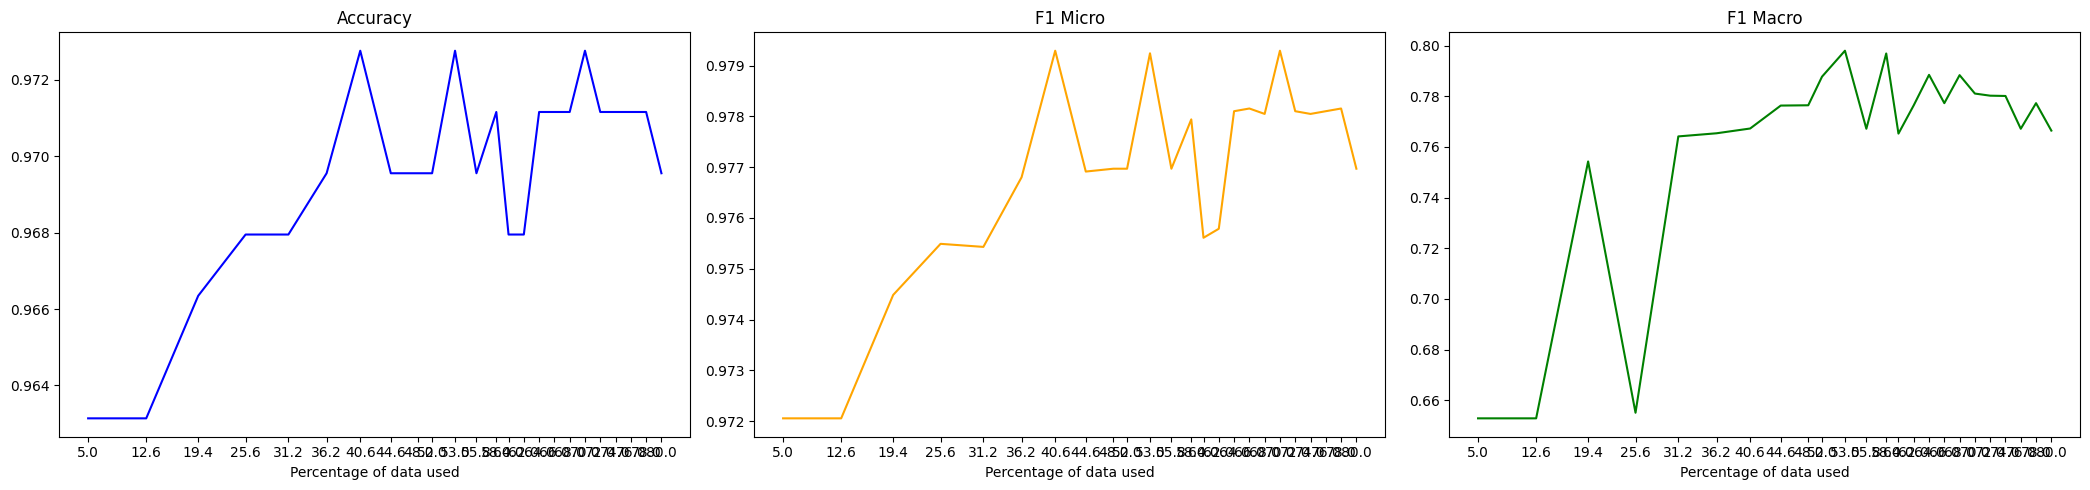

In [ ]:
active_learning(seeds[4], 4)